# Example: Simulating a MAST-U shot using input data from EFIT++ (via pyUDA)

This example notebook will show how to carry out static forward Grad-Shafranov equilibrium solves for MAST-U shots using FreeGSNKE. This example will follow the methodology for solving the GS equation in FreeGSNKE laid out in [Pentland et al. (2024)](https://arxiv.org/abs/2407.12432).

We will:
 - load the MAST-U machine description (from pyUDA).
 - load the input parameters from EFIT++ **magnetics and motional Stark effect (MSE)** reconstructions of a given shot (inputs required for each time slice being simulated). These include the coil currents and profile functions/parameters (plus some other quantities). We'll do some input checking to ensure no spurious parameters exist. 
 - simulate the shot using FreeGSNKE's static forward solver.
 - compare poloidal flux and shape control targets between FreeGSNKE and the EFIT++ reconstructions.

To re-familiarise yourself with the static forward solver in FreeGSNKE, revist the "example1" notebooks. 

**Note**: This notebook can only be run with access to a UDA client (or run via the Freia cluster at UKAEA). 

## Import packages

In [1]:
import numpy as np
import pickle
import time
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

# freegs4e/freegsnke modules (other may be needed later)
import freegs4e
from freegsnke import equilibrium_update, GSstaticsolver, mastu_tools

In [2]:
# these paths are required to be able to access the MAST-U data via the UDA module
os.environ["UDA_HOST"] = "uda2.hpc.l"
# os.environ["UDA_HOST"] = "data.mastu.ukaea.uk"
os.environ["UDA_PORT"] = "56565"
os.environ["UDA_META_PLUGINNAME"] = "MASTU_DB"
os.environ["UDA_METANEW_PLUGINNAME"] = "MASTU_DB"

# initialise the pyuda client to access the data
import pyuda
client = pyuda.Client()

## Select MAST-U shot that you wish to simulate

In [3]:
# MAST-U shot number (make sure it's a valid shot with EFIT++ equilibrium reconstruction data!)
shot = 45425

## Build the MAST-U machine

Next, we build the MAST-U machine object. This can be done using the geometry data from a particular shot number via the 'get_machine_data' function below.

FreeGSNKE requires the following envirnoment variables in order to build the machine: ACTIVE_COILS_PATH, PASSIVE_COILS_PATH, WALL_PATH, LIMITER_PATH, PROBE_PATH. 

Note 1: There are two options used for building the active coils in FreeGSNKE. The first sets up **symmetric** coils where the corresponding up/down coils in MAST-U (e.g. P4_upper and P4_lower) are wired **in series** and therefore will be assigned the same current value later. The second option sets up **non-symmetric** coils in which the up/down coils are modelled independently and can be assigned **different** currents (i.e. they are **not wired in series**). Set the 'symmetric_machine' parameter to either 'True' or 'False' to toggle this setting. We use the **non-symmetric** setting here as the coil currents in EFIT++ are calculated independently (though you may test out the symmetric case too to see the differences). 

Note 2: The magnetic probes are not used in this script (see "example1c" for how to use them). 

In [4]:
# This function will pull machine geoemtry data from the shot number.
# 'split_passive=True' means the passives structures will be modelled as parallelograms with current
# distributed evenly over their cross-sectional area (which is reccomended), setting to 'False' will
# model them as point sources (less accurate for parallelograms with large surface areas).
mastu_tools.get_machine_data(save_path="../machine_configs/MAST-U", shot=shot, split_passives=True)

MAST-U geometry data successfully extracted and pickle files built.


In [5]:
# set paths (choose symmetric or non-symmetric active coils)
symmetric_machine = False
if symmetric_machine:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils.pickle"
else:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils_nonsym.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_limiter.pickle"
os.environ["PROBE_PATH"] = f"../machine_configs/MAST-U/MAST-U_magnetic_probes.pickle"

# now the machine can actually be built
from freegsnke import build_machine
tokamak = build_machine.tokamak()

## Load the required input data from the EFIT++ reconstructions
Here, we load the parameters required by the static forward GS solver (at each independent EFIT++ time step). They include the:
 - plasma current ($I_p$).
 - fvac parameter (= $r B_{tor}$).
 - profile function coefficients (pp_knots, pp_values, pp_tension for $p'$ and ffp_knots, ffp_values, ffp_tension for $FF'$.
 - active coil and passive structure currents (loads currents for both symmetric and non-symmetric active coil setups).
    
Note 1: The function loads values for all time steps in the EFIT++ reconstruction (including time steps that may have failed to converge - we will exclude these later on).

Note 2: There is also the option to set the passive structure currents to zero if desired. 

Note 3: For **magnetics and MSE** EFIT++ reconstructions, the following spline functions are used to parameterise the pressure and toroidal current density profiles, respectively:

$$
\frac{dp}{d \hat{\psi}} = \sum_{n=0}^{n_p - 1} f_n(\hat{\psi}),
$$

$$
F \frac{dF}{d \hat{\psi}} = \sum_{n=0}^{n_F - 1} f_n(\hat{\psi}).
$$

Where:
-  $\hat{\psi}$ is the normalised flux.
-  $f_n(x)$ are the "tension spline" functions (see [here for an overview](https://catxmai.github.io/pdfs/Math212_ProjectReport.pdf)):
$$ 
f_n(x) = 
\begin{cases} 
y_n \frac{x_{n+1} - x}{x_{n+1} - x_n} + \frac{z_n}{\sigma^2} \left[ \frac{\sinh(\sigma (x_{n+1} - x) )}{\sinh(\sigma (x_{n+1} - x_n) )} - \frac{x_{n+1} - x}{x_{n+1} - x_n} \right] + \frac{z_{n+1}}{\sigma^2} \left[ \frac{\sinh(\sigma (x - x_n) )}{\sinh(\sigma (x_{n+1} - x_n) )} - \frac{x - x_n}{x_{n+1} - x_n} \right] + y_{n+1} \frac{x - x_n}{x_{n+1} - x_n} & \text{if } x \in [x_n, x_{n+1}], \\
0 & \text{otherwise}
\end{cases}
$$
    
which require some **additional parameters** that are **different** for $p'$ and $FF'$ even though we abuse notation and use $f_n(x)$ in both definitions above. We now describe the parameters for $p'$ below (they are analagously similar for $FF'$):
   - the values $x_n$ for $n = 0,\ldots,n_p$ (which are defined as $(\hat{\psi}_0, \ldots, \hat{\psi}_{n_p})$) are the **knot points**. These are the locations in the $\hat{\psi}$ interval (i.e. [0,1]) where values of the profile and its second derivative (see below) have been calculated (by EFIT++). These are defined in 'pp_knots' below.
   - $y_n = f(x_n)$ for $n = 0,\ldots,n_p$ are the known **values of the profile function** at the knot points. These are defined in 'pp_values' below.
   - $z_n = f''(x_n)$ for $n = 0,\ldots,n_p$ are the known **values of the second derivative of the profile function** at the knot points. These are defined in 'pp_values_2nd' below.
   - $\sigma > 0$ is the **tension** parameter ($\sigma \rightarrow \infty$ corresponds to a piecewise linear spline, whilst smaller $\sigma$ results in a more smooth fit).

**Aside**: an example of how this works for a given time slice is shown later on. Also, at the end of this notebook an even simpler example of how the tension spline works for a cubic polynomial is shown. 

In [6]:
# load the parameters
Ip, fvac, pp_knots, ffp_knots, pp_values, ffp_values, pp_values_2nd, ffp_values_2nd, pp_tension, ffp_tension, currents, currents_nonsym, _ = mastu_tools.load_static_solver_inputs_splines(
    client=client,        # pyuda client
	shot=shot,            # shot number
	zero_passives=False   # set passive structure currents to zero? (True or False)
    )

We now load the shot times at which the EFIT++ reconstructions were carried out (which correspond to the above data) and check which time slices successfully converged. This is important because we need to exclude those that failed to converge (typically these occur during the ramp-up and ramp-dwn of the plasma). 

In [7]:
# load the efit reconstruction timestamps and convergence status
# Note: efit_times that have efit_status=-1 did not converge so we will exclude those time slices
efit_times, efit_status = mastu_tools.load_efit_times_and_status_splines(client=client, shot=shot)

# figure out which time slices did not converge
time_indices = np.where(efit_status == 1)[0]
time_slices_excluded = np.where(efit_status == -1)[0]
print(f"{len(time_slices_excluded)} time slices (out of total {len(efit_times)}) excluded from simulation.")
print(f"The excluded time slices are: {efit_times[time_slices_excluded]} seconds.")

times = efit_times[time_indices]  # these are the slices we simulate
print(f"Total time slices to be simulated: {len(times)}.")


0 time slices (out of total 188) excluded from simulation.
The excluded time slices are: [] seconds.
Total time slices to be simulated: 188.


Let us plot some of the input parameters over these times to check they are indeed valid (as we may need to exclude some more if EFIT++ failed to catch the non-convergence).

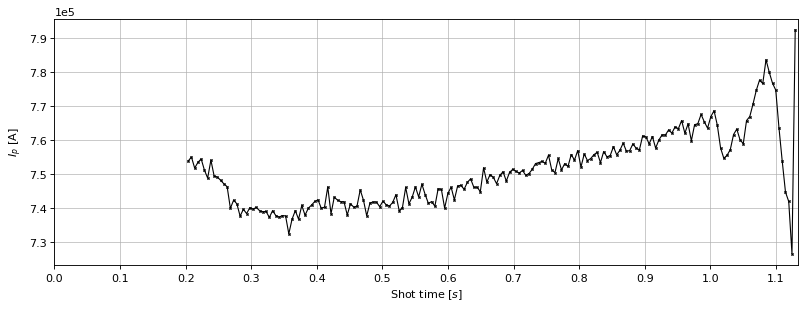

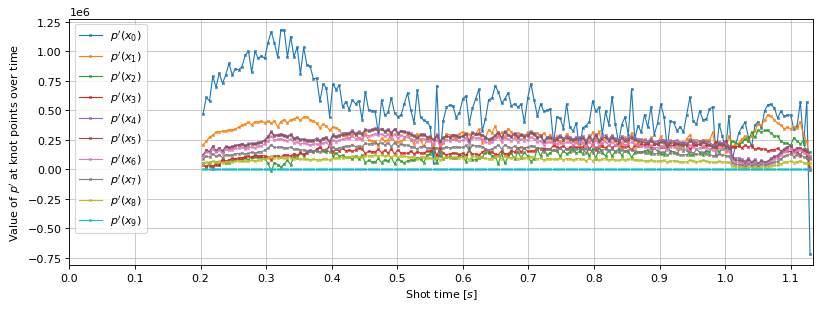

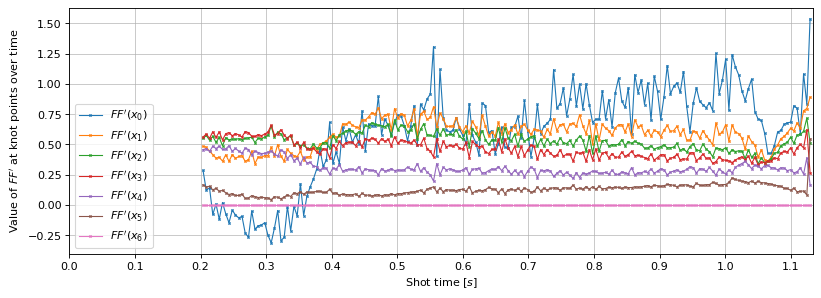

In [8]:
fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, Ip[time_indices], color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$I_p$ [A]')
ax1.set_xticks(np.arange(0, times[-1], 0.1))
ax1.set_xlim(0, times[-1] + 0.005)
ax1.ticklabel_format(axis='y', scilimits=(0,0))

fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
for i in range(0,len(pp_values[0,:])):
    ax1.plot(times, pp_values[time_indices,i], linewidth=1, marker='x', markersize=2, zorder=10, label=rf"$p'(x_{i})$")
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r"Value of $p'$ at knot points over time")
ax1.set_xticks(np.arange(0, times[-1], 0.1))
ax1.set_xlim(0, times[-1] + 0.005)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "upper left")

fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
for i in range(0,len(ffp_values[0,:])):
    ax1.plot(times, ffp_values[time_indices,i], linewidth=1, marker='x', markersize=2, zorder=10, label=rf"$FF'(x_{i})$")
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r"Value of $FF'$ at knot points over time")
ax1.set_xticks(np.arange(0, times[-1], 0.1))
ax1.set_xlim(0, times[-1] + 0.005)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "lower left")

We can see that the profile parameters (and plasma current) are slightly spurious at the final time slice and so we can cut those off.

In [9]:
time_indices = time_indices[0:-1]
times = efit_times[time_indices]
n = len(times)

### Side example: plotting the spline profiles at a given time slice

Here, we will plot the $p'$ and $FF'$ profiles at a given time slice to see what they look like. Note that here we're showing how they can be constructed from the spline parameters alone - once the `profiles` objects have been initialised later on, they can be plotted directly from them. 

First, we'll select a time slice and exctract the parameters. 

In [10]:
index = time_indices[94]
times[index]

0.66914

In [11]:
psi_n = np.linspace(0,1,65)                       # normalised flux from values 0 (at magnetic axis) to 1 (at plasma boundary)
pp_knot_points = pp_knots[index,:]                # select the knot points from the relevant time slice
ffp_knot_points = ffp_knots[index,:]              # same
pp_knot_values = pp_values[index,:]               # select the values at the knot points from the relevant time slice
ffp_knot_values = ffp_values[index,:]             # same
pp_knot_values_2nd = pp_values_2nd[index,:]       # select the values of the second derivative at the knot points from the relevant time slice
ffp_knot_values_2nd = ffp_values_2nd[index,:]     # same

pp_tension_val = pp_tension[index]                     # select the tension value the relevant time slice
ffp_tension_val = ffp_tension[index]                  # same

In [12]:
# this function reconstructs the function from the spline parameters above
def tension_spline(x, xn, yn, zn, sigma):

    # fixed parameters
    x_diffs = xn[1:] - xn[0:-1]
    sinh_diffs = np.sinh(sigma*x_diffs)
    
    # initial solution array (each column is f_n(x) for a different n)
    X = np.tile(x,(len(x_diffs),1)).T

    # calculate the terms in the spline (vectorised)
    t1 = (yn[0:-1] - zn[0:-1]/(sigma**2))*((xn[1:] - X)/x_diffs)
    t2 = (zn[0:-1]*np.sinh(sigma*(xn[1:] - X)) + zn[1:]*np.sinh(sigma*(X - xn[0:-1])))/((sigma**2)*sinh_diffs)
    t3 = (yn[1:] - zn[1:]/(sigma**2))*((X - xn[0:-1])/x_diffs)

    # sum the values
    sol = t1 + t2 + t3
    
    # zero out values outisde range of each f_n(x) as they're not valid (recall definition of tension spline)
    for n in range(0, len(xn)-1):
        ind = (xn[n] <= x) & (x <= xn[n+1])
        sol[~ind,n] = 0
    
    # sum to find (alomst) final solution
    f = np.sum(sol, axis=1)

    # check if any of the interpolation and knot points are the same (if so we have double counted)
    for i in np.where(np.isin(x, xn))[0]:
        if i not in [0,len(x)-1]:
            f[i] /= 2
    return f

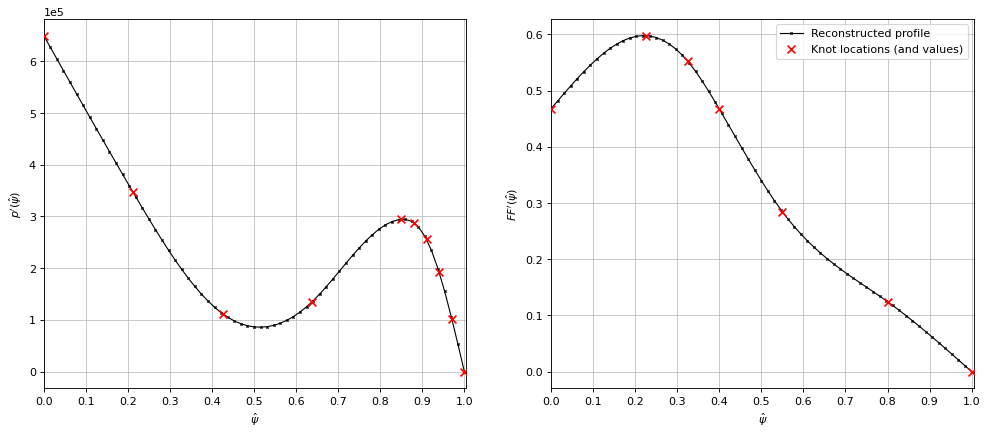

In [13]:
# call the function and plot

pprime = tension_spline(psi_n, pp_knot_points, pp_knot_values, pp_knot_values_2nd, pp_tension_val)
ffprime = tension_spline(psi_n, ffp_knot_points, ffp_knot_values, ffp_knot_values_2nd, ffp_tension_val)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, pprime, color='k', linewidth=1, marker='x', markersize=2, zorder=10, label="Reconstructed profile")
ax1.scatter(pp_knot_points, pp_knot_values, color='r', marker='x', s=50, zorder=12, label="Knot locations (and values)")
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$p'(\hat{\psi})$")
ax1.set_xticks(np.arange(0, 1.05, 0.1))
ax1.set_xlim(0, 1 + 0.005)
ax1.ticklabel_format(axis='y', scilimits=(0,0))

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(psi_n, ffprime, color='k', linewidth=1, marker='x', markersize=2, zorder=10, label="Reconstructed profile")
ax2.scatter(ffp_knot_points, ffp_knot_values, color='r', marker='x', s=50, zorder=12, label="Knot locations (and values)")
ax2.set_xlabel(r'$\hat{\psi}$')
ax2.set_ylabel(r"$FF'(\hat{\psi})$")
ax2.set_xticks(np.arange(0, 1.05, 0.1))
ax2.set_xlim(0, 1 + 0.005)
ax2.legend(loc="upper right")


Note, the difference between these profiles and the ones in the prior notebook (they're plotted around the same time slice). 

## Initialise the equilibrium object and static solver
Here we initialise the equilibrium object as we have in the previous example scripts. We use the same rectangular computational grid and domain as used by EFIT++ for easy comparison later on (we could use a denser grid, however, we would need to interpolate some things later on). 

We also load FreeGSNKE's static GS solver (can be used for forward and inverse solves but here we use for forward only). 

Note 1: It is not necessary to instantiate a new solver object when using it to solve for multiple different equilibria, as long as the integration domain, mesh grid, and tokamak required are identical. If you wish to modify these values for the same/different equilibria then you will need to instatiate new objects. 

In [14]:
# equilibrium object (note that both nx and ny have to be of the form 2**n + 1 with n being an integer)
eq = equilibrium_update.Equilibrium(
tokamak=tokamak,             # sets up the object with the MAST-U tokamak
Rmin=0.06, Rmax=2.0,         # computational grid radial limits (same as EFIT++)
Zmin=-2.2, Zmax=2.2,         # computational grid vertical limits (same as EFIT)
nx=65,                       # number of grid points in the radial direction
ny=65,                       # number of grid points in the vertical direction
psi=None                     # initial guess for the plasma flux (can provide one if available)
) 

In [15]:
# static solver object (used for solving later on)
solver = GSstaticsolver.NKGSsolver(eq)  

## Use FreeGSNKE to solve the static forward GS equation at each time slice

We are finally ready to solve the static forward GS problem using FreeGSNKE. This will be done sequentially in a loop over the times that we wish to simulate (setting this up to run in parallel would be cool). 

In [16]:
from freegsnke import jtor_update # for initialising the profile object
from copy import deepcopy

# carry out the simulation and store some quantities of interest
freegsnke_eqs = []
freegsnke_profiles = []
freegsnke_runtimes = []
for i in time_indices:

    # strings for dictionary keys
    time_str = str(efit_times[i]).replace(".", "")
    name = f"shot_{shot}_time_{time_str}"

    # start timer
    start_time = time.time()

    print(f"-----Solving equilibrium for shot {shot} at time {efit_times[i]}-----")
    
    # initialise profile object
    profiles = jtor_update.TensionSpline(
        eq=eq,                                          # equilibrium object
        limiter=tokamak.limiter,                        # plasma limiter
        Ip=Ip[i],                                       # total plasma current
        fvac=fvac[i],                                   # f vacuum parameter (R*Bt)
        pp_knots = pp_knots[i,:],                       # pprime knot points
        pp_values = pp_values[i,:],                     # pprime values at the knot points 
        pp_values_2 = pp_values_2nd[i,:],               # pprime second deriv. values at the knot points 
        pp_sigma = pp_tension[i],                       # pprime tension value
        ffp_knots = ffp_knots[i,:],                     # ffprime knot points
        ffp_values = ffp_values[i,:],                   # ffprime values at the knot points 
        ffp_values_2 = ffp_values_2nd[i,:],             # ffprime second deriv. values at the knot points 
        ffp_sigma = ffp_tension[i],                     # ffprime tension value
    )
    
    # set coil currents in eq object
    # checks if machine is up/down symmetric or not
    if symmetric_machine:
        for key in currents_sym.keys():
            eq.tokamak[key].current = currents_sym[key][i]
    else:
        for key in currents_nonsym.keys():
            eq.tokamak[key].current = currents_nonsym[key][i]
     
    # carry out the forward solve
    solver.solve(eq=eq,
                 profiles=profiles,
                 constrain=None,
                 target_relative_tolerance=1e-6,
                )

    # stop timer
    end_time = time.time()

    # store data
    freegsnke_eqs.append(deepcopy(eq))
    freegsnke_profiles.append(deepcopy(profiles))
    freegsnke_runtimes.append(end_time - start_time)


print("-----SIMULATIONS COMPLETE!-----")

-----Solving equilibrium for shot 45425 at time 0.20384-----
-----Solving equilibrium for shot 45425 at time 0.2088-----
-----Solving equilibrium for shot 45425 at time 0.21374-----
-----Solving equilibrium for shot 45425 at time 0.2187-----
-----Solving equilibrium for shot 45425 at time 0.22365-----
-----Solving equilibrium for shot 45425 at time 0.22859-----
-----Solving equilibrium for shot 45425 at time 0.23355-----
-----Solving equilibrium for shot 45425 at time 0.2385-----
-----Solving equilibrium for shot 45425 at time 0.24344-----
-----Solving equilibrium for shot 45425 at time 0.2484-----
-----Solving equilibrium for shot 45425 at time 0.25334-----
-----Solving equilibrium for shot 45425 at time 0.25829-----
-----Solving equilibrium for shot 45425 at time 0.26325-----
-----Solving equilibrium for shot 45425 at time 0.2682-----
-----Solving equilibrium for shot 45425 at time 0.27315-----
-----Solving equilibrium for shot 45425 at time 0.27809-----
-----Solving equilibrium for 

Notice that the FreeGSNKE runtimes might be slower than as reported in [Pentland et al. (2024)](https://arxiv.org/abs/2407.12432) becuase this script is run directly on Freia (which is slow!) rather than on a faster MacBook Pro machine...

In [17]:
print(f"Median FreeGSNKE runtime per time slice = {np.median(freegsnke_runtimes)} seconds.")
print(f"Total FreeGSNKE runtime = {np.sum(freegsnke_runtimes)} seconds.")

Median FreeGSNKE runtime per time slice = 0.13733601570129395 seconds.
Total FreeGSNKE runtime = 27.38707661628723 seconds.


This is how you would retreive the profile shapes (same for ffprime). 

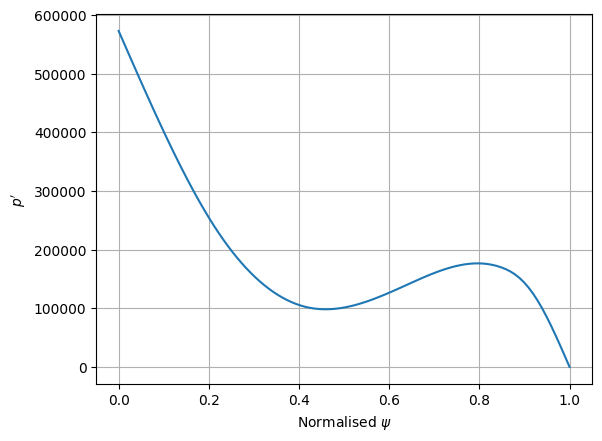

In [18]:
plt.plot(np.linspace(0,1,100),profiles.pprime(np.linspace(0,1,100)))
plt.xlabel(r'Normalised $\psi$')
plt.ylabel(r"$p'$")
plt.grid()
plt.show()

## Compare FreeGSNKE simulations with EFIT++ reconstructions
Here, we can compare some of the quantites produced by the FreeGSNKE simulations and the EFIT++ reconstructions. 

How to access some of the important quantities of interest in FreeGSNKE are listed below (there are more!):
- "psi_total" = eq.psi()
- "psi_plasma" = eq.plasma_psi
- "psi_coils" = eq.tokamak_psi
- "psi_axis" = eq.psi_axis
- "psi_boundary" = eq.psi_bndry
- "Jtor" = profiles.jtor
- "magnetic_axis" = eq.magneticAxis()[0:2]
- "midplane_inner_outer_radii" = eq.innerOuterSeparatrix(0)
- "x_points" = eq.xpt[:,0:2]
- "pprime" = eq.pprime(np.linspace(0,1,65))/profiles.L
- "ffprime" = eq.ffprime(np.linspace(0,1,65))/profiles.L
- "strike_points" = find_strikepoints(R=eq.R, Z=eq.Z, psi_total=eq.psi(), psi_boundary=eq.psi_bndry, limiter=np.array([eq.tokamak.limiter.R,eq.tokamak.limiter.Z]).T)


First, however, we need to extract the EFIT++ output data that we want to compare. This is done via the 'extract_EFIT_outputs' function. 

In [19]:
efit_psi_total, efit_psi_axis, efit_psi_boundary, efit_jtor, efit_magnetic_axis, efit_midplane_inner_outer_radii, efit_x_points, efit_pprime, efit_ffprime, efit_strike_points, efit_fluxloops, efit_pickups = mastu_tools.extract_EFIT_outputs_splines(client=client, shot=shot, time_indices=time_indices)


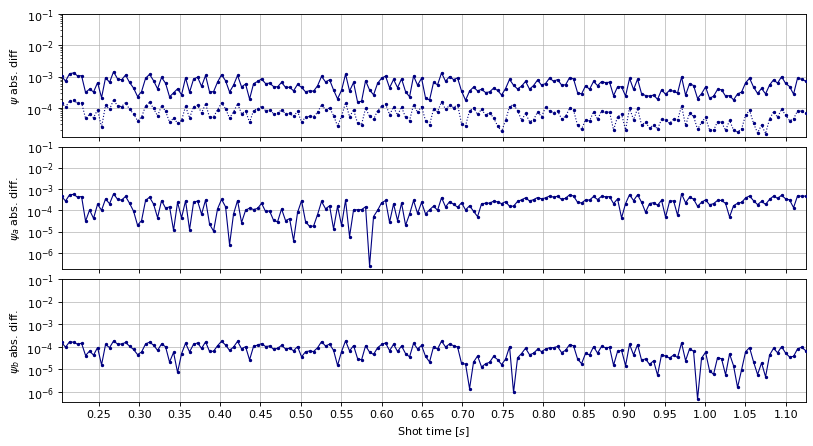

In [20]:
# PSI QUANTITIES
# -------------
psi_total_err = np.zeros(n)
psi_total_err_med = np.zeros(n)
psi_axis_err = np.zeros(n)
psi_bndry_err = np.zeros(n)
for i in range(0, n):
    psi_total_err[i] = np.max(np.abs(freegsnke_eqs[i].psi() - efit_psi_total[i,:,:]))
    psi_total_err_med[i] = np.median(np.abs(freegsnke_eqs[i].psi() - efit_psi_total[i,:,:]))
    psi_axis_err[i] = np.abs(freegsnke_eqs[i].psi_axis - efit_psi_axis[i])
    psi_bndry_err[i] = np.abs(freegsnke_eqs[i].psi_bndry - efit_psi_boundary[i])


fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6.3), dpi=80)
plt.subplots_adjust(hspace=0.08)  # Adjust the horizontal space between subplots

ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, psi_total_err, color='navy',  linewidth=1, marker='.', markersize=4, label='FreeGSNKE', zorder=10) 
ax1.plot(times, psi_total_err_med, color='navy', linestyle='dotted', linewidth=1, marker='.', markersize=4, zorder=10) 
ax1.set_ylabel(r'$\psi$ abs. diff')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(0,max(times)+0.1, 0.05))
ax1.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
ax1.set_xticklabels([])
ax1.set_xlim(min(times), max(times))
ax1.set_axisbelow(True)

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(times, psi_axis_err, color='navy', marker='.', markersize=4, linewidth=1, label='FreeGSNKE', zorder=10) 
ax2.set_ylabel(r'$\psi_a$ abs. diff.')
ax2.set_yscale('log')
ax2.set_xticks(np.arange(0,max(times)+0.1,0.05))
ax2.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax2.set_xticklabels([])
ax2.set_xlim(min(times), max(times))
ax2.set_axisbelow(True)

ax3.grid(zorder=0, alpha=0.75)
ax3.plot(times, psi_bndry_err, color='navy', marker='.', markersize=4, linewidth=1, label='FreeGSNKE', zorder=10) 
ax3.set_xlabel(r'Shot time [$s$]')
ax3.set_ylabel(r'$\psi_b$ abs. diff.')
ax3.set_yscale('log')
ax3.set_xticks(np.arange(0,max(times)+0.1,0.05))
ax3.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax3.set_xlim(min(times), max(times))
ax3.set_axisbelow(True)
plt.show()

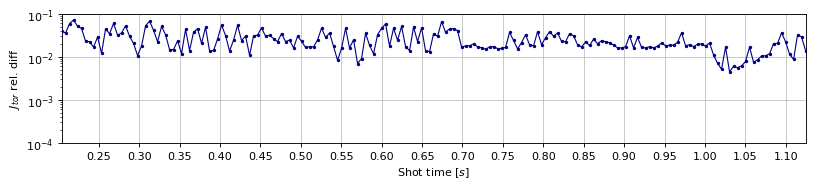

In [21]:
# Jtor 
# -------------
jtor_total_err = np.zeros(n)

for i in range(0, n):
    jtor_total_err[i] = np.max(np.abs(freegsnke_profiles[i].jtor - efit_jtor[i,:,:]))/np.max(np.abs(efit_jtor[i,:,:]))


fig1, ax1 = plt.subplots(1, 1, figsize=(12, 2.1), dpi=80)
plt.subplots_adjust(hspace=0.08)  # Adjust the horizontal space between subplots

ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, jtor_total_err, color='navy',  linewidth=1, marker='.', markersize=4, label='FreeGSNKE', zorder=10) 
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$J_{tor}$ rel. diff')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(0,max(times)+0.1, 0.05))
ax1.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
ax1.set_xlim(min(times), max(times))
ax1.set_axisbelow(True)
plt.show()

/Users/kpentlan/Documents/Projects/Software/freegs4e/freegs4e/critical.py:830: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")


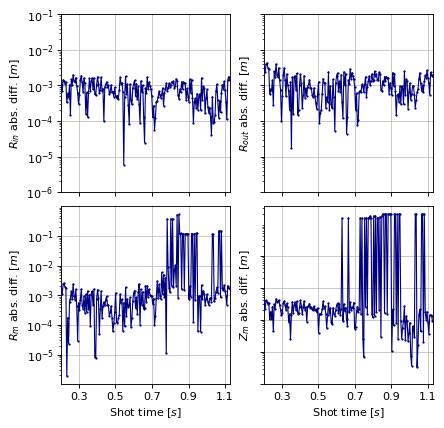

In [22]:
# SHAPE/POSITION QUANTITIES
# -------------

inner_r_err = np.zeros(n)
outer_z_err = np.zeros(n)
mag_r_err = np.zeros(n)
mag_z_err = np.zeros(n)
for i in range(0,n):

    inner_r_err[i] = np.abs(freegsnke_eqs[i].innerOuterSeparatrix(0)[0] -  efit_midplane_inner_outer_radii[i,0])
    outer_z_err[i] = np.abs(freegsnke_eqs[i].innerOuterSeparatrix(0)[1] -  efit_midplane_inner_outer_radii[i,1])
    mag_r_err[i] = np.abs(freegsnke_eqs[i].magneticAxis()[0] -  efit_magnetic_axis[i,0])
    mag_z_err[i] = np.abs(freegsnke_eqs[i].magneticAxis()[1] -  efit_magnetic_axis[i,1])

fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 6), dpi=80)
plt.subplots_adjust(wspace=0.2, hspace=0.08)

ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, inner_r_err, color='navy',  linewidth=1, marker='.', markersize=2, label='FreeGSNKE', zorder=10) 
ax1.set_ylabel(r'$R_{in}$ abs. diff. [$m$]')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(0.1,max(times)+0.1,0.2))
ax1.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax1.set_xticklabels([])
ax1.set_xlim(min(times), max(times)+0.005)
ax1.set_axisbelow(True)

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(times, outer_z_err, color='navy',  linewidth=1, marker='.', markersize=2, label='FreeGSNKE', zorder=10) 
ax2.set_ylabel(r'$R_{out}$ abs. diff. [$m$]')
ax2.set_yscale('log')
ax2.set_xticks(np.arange(0.1,max(times)+0.1,0.2))
ax2.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlim(min(times), max(times)+0.005)
ax2.set_axisbelow(True)

ax3.grid(zorder=0, alpha=0.75)
ax3.plot(times, mag_r_err, color='navy',  linewidth=1, marker='.', markersize=2, label='FreeGSNKE', zorder=10) 
# ax3.set_aspect('equal')
ax3.set_xlabel(r'Shot time [$s$]')
ax3.set_ylabel(r'$R_{m}$ abs. diff. [$m$]')
ax3.set_yscale('log')
ax3.set_xticks(np.arange(0.1,max(times)+0.1,0.2))
ax3.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax3.set_xlim(min(times), max(times)+0.005)
ax3.set_axisbelow(True)

ax4.grid(zorder=0, alpha=0.75)
ax4.plot(times, mag_z_err, color='navy',  linewidth=1, marker='.', markersize=2, label='FreeGSNKE', zorder=10) 
ax4.set_xlabel(r'Shot time [$s$]')
ax4.set_ylabel(r'$Z_{m}$ abs. diff. [$m$]')
ax4.set_yscale('log')
ax4.set_xticks(np.arange(0.1,max(times)+0.1,0.2))
ax4.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax4.set_yticklabels([])
ax4.set_xlim(min(times), max(times)+0.005)
ax4.set_axisbelow(True)
plt.show()

In [23]:
# X-POINTS 
# -------------
# the x point calculation in EFIT doesn't seem to yield good results so we use FreeGSNKE's built-in calculator here

from freegs4e import critical

xpoints_freegsnke = np.zeros((n,2))
xpoints_fiesta = np.zeros((n,2))
xpoints_efit = np.zeros((n,2))


box = [0.3, 0.7, -1.4, -1.0]  # box in which to search for xpoints (can change if needed)
for i in range(0, n):

    # ------------------
    # efit x-points (calculated using FreeGSNKE function)
    opt, xpt = critical.find_critical(eq.R, eq.Z, efit_psi_total[i,:,:])
    if len(xpt) == 0:
        xpoints_efit[i] = [None, None]
    else:
        XPT = np.array(xpt)
        x_r = XPT[:,0]
        x_z = XPT[:,1]
        ind =  np.where((box[0] < x_r) & (x_r < box[1]) & (box[2] < x_z) & (x_z < box[3]))[0]
        if len(ind) == 0:       
            xpoints_efit[i,:] = None
        else:
            xpoint_r = deepcopy(x_r[ind[0]])
            xpoint_z = deepcopy(x_z[ind[0]])
            xpoints_efit[i,:] = np.array([xpoint_r, xpoint_z])


    # ------------------
    # freegsnke x-points (calculated using FreeGSNKE function)
    x_r = freegsnke_eqs[i].xpt[:,0]
    x_z = freegsnke_eqs[i].xpt[:,1]
    ind = np.where((box[0] < x_r) & (x_r < box[1]) & (box[2] < x_z) & (x_z < box[3]))[0]
    if len(ind) == 0:       
        xpoints_freegsnke[i] = None
    else:
        xpoints_freegsnke[i,:] = deepcopy([x_r[ind[0]], x_z[ind[0]]])

freegsnke_xpoint_err = xpoints_freegsnke - xpoints_efit

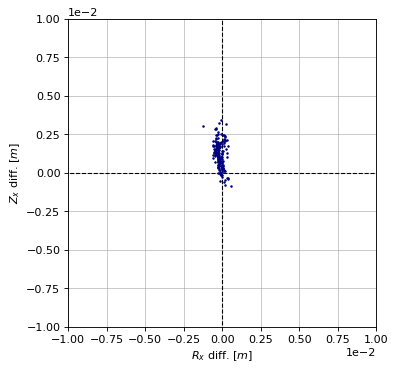

In [24]:
fig3, ax1 = plt.subplots(1, 1, figsize=(5, 5), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.axvline(x=0, ymin=-1, ymax=1, linestyle='--', linewidth=1, color='k')
ax1.axhline(y=0, xmin=-1, xmax=1, linestyle='--', linewidth=1, color='k')
ax1.scatter(freegsnke_xpoint_err[:,0],freegsnke_xpoint_err[:,1], color='navy', s=6, marker='.', label='FreeGSNKE', zorder=10)
# ax1.scatter(0, 0, color='r', marker='*', zorder=11) 
ax1.set_aspect('equal')
ax1.set_xlabel(r'$R_{x}$ diff. [$m$]')
ax1.set_ylabel(r'$Z_{x}$ diff. [$m$]')
ax1.set_xlim(-0.01, 0.01)
ax1.set_ylim(-0.01, 0.01)
ax1.set_axisbelow(True)
ax1.ticklabel_format(axis='both', scilimits=(0,0))
plt.show()

In [25]:
# STRIKEPOINTS (lower divertor chamber)
# -------------
# again, we use our own calculator for finding the strikepoints

strikes_freegsnke = np.zeros((n,2))
strikes_efit = np.zeros((n,2))

# which strikepoint are we looking for?
# (lower right hand corner of domain in this case)
r_min = 0.5
z_max = -1.5
for i in range(0, n):

    # ------------------
    # freegsnke strikepoints
    s = mastu_tools.find_strikepoints(R=eq.R, 
                          Z=eq.Z, 
                          psi=freegsnke_eqs[i].psi(), 
                          psi_boundary=freegsnke_eqs[i].psi_bndry, 
                          wall=np.array([eq.tokamak.limiter.R,eq.tokamak.limiter.Z]).T)
    s_r = s[:,0]
    s_z = s[:,1]
    ind = np.where((s_r > r_min) & (s_z < z_max))[0]
    if len(np.where((s_r > r_min) & (s_z < z_max))[0]) == 0:       
        strikes_freegsnke[i] = None
    else:
        strikes_freegsnke[i,:] = np.array([s_r[ind[0]], s_z[ind[0]]])

    # ------------------
    # efit strikepoints (calculated using FreeGSNKE function)
    efit_strikes_list = mastu_tools.find_strikepoints(R=eq.R,
                                    Z=eq.Z,
                                    psi=efit_psi_total[i,:,:], 
                                    psi_boundary=efit_psi_boundary[i],
                                    wall=np.array([eq.tokamak.limiter.R,eq.tokamak.limiter.Z]).T)

    try:
        s_r = efit_strikes_list[:,0]
        s_z = efit_strikes_list[:,1]
        ind = np.where((s_r > r_min) & (s_z < z_max))[0]
        if len(np.where((s_r > r_min) & (s_z < z_max))[0]) == 0:       
            strikes_efit[i] = None
        else:
            strikes_efit[i] = np.array([s_r[ind[0]], s_z[ind[0]]])
    except:
        strikes_efit[i] = None


freegsnke_strikes_err = strikes_freegsnke - strikes_efit


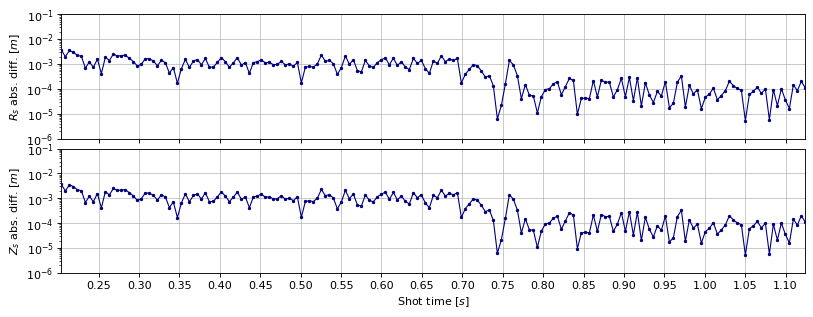

In [26]:
fig4, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(12, 4.2), dpi=80)
plt.subplots_adjust(hspace=0.08)  # Adjust the horizontal space between subplots

ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, np.abs(strikes_freegsnke[:,0] - strikes_efit[:,0]), color='navy',  linewidth=1, marker='.', markersize=4, label='FreeGSNKE', zorder=10) 
ax1.set_ylabel(r'$R_{s}$ abs. diff. [$m$]')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(0,max(times)+0.1,0.05))
ax1.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax1.set_xlim(min(times), max(times))
ax1.set_xticklabels([])
ax1.set_axisbelow(True)

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(times, np.abs(strikes_freegsnke[:,1] - strikes_efit[:,1]), color='navy',  linewidth=1, marker='.', markersize=4, label='FreeGSNKE', zorder=10) 
ax2.set_xlabel(r'Shot time [$s$]')
ax2.set_ylabel(r'$Z_{s}$ abs. diff. [$m$]')
ax2.set_yscale('log')
ax2.set_xticks(np.arange(0,max(times)+0.1,0.05))
ax2.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax2.set_xlim(min(times), max(times))
ax2.set_axisbelow(True)
plt.show()

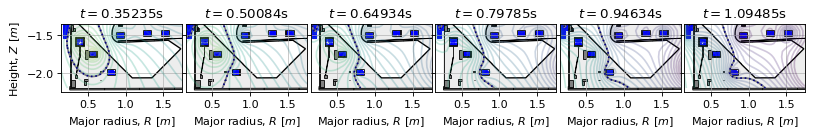

In [27]:
# some snapshots of the lower divertor for FreeGSNKE equilibria
snaps = [30, 60, 90, 120, 150, 180]

# common contour levels
levels = np.linspace(np.min(efit_psi_total[snaps[1],:,:]),np.max(efit_psi_total[snaps[1],:,:]),40)

fig5, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(12, 6.3), dpi=80)
plt.subplots_adjust(wspace=0.03)  # Adjust the horizontal space between subplots

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax1.add_patch(rect0)
eq.tokamak.plot(axis=ax1, show=False)
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax1.contour(eq.R, eq.Z, freegsnke_eqs[snaps[0]].psi(), levels=levels, alpha=0.25)
ax1.contour(eq.R, eq.Z, efit_psi_total[snaps[0],:,:], levels=[efit_psi_boundary[snaps[0]]], colors='tab:gray', linestyles = 'solid')
ax1.contour(eq.R, eq.Z, freegsnke_eqs[snaps[0]].psi(), levels=[freegsnke_eqs[snaps[0]].psi_bndry], colors='navy', linestyles = 'dotted')
ax1.grid(alpha=0.75)
ax1.set_aspect('equal')
ax1.set_xlabel(r'Major radius, $R$ $[m]$')
ax1.set_ylabel(r'Height, $Z$ $[m]$')
# ax1.set_xlim((0/2) + 0.15, (2.15/2) + 0.15)
ax1.set_xlim((0/1) + 0.15, 1.75)
ax1.set_ylim(-2.25, -1.35)
ax1.set_title(f"$t = {times[snaps[0]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax2.add_patch(rect0)
eq.tokamak.plot(axis=ax2, show=False)
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax2.contour(eq.R, eq.Z, freegsnke_eqs[snaps[1]].psi(), levels=levels, alpha=0.25)
ax2.contour(eq.R, eq.Z, efit_psi_total[snaps[1],:,:], levels=[efit_psi_boundary[snaps[1]]], colors='tab:gray', linestyles = 'solid')
ax2.contour(eq.R, eq.Z, freegsnke_eqs[snaps[1]].psi(), levels=[freegsnke_eqs[snaps[1]].psi_bndry], colors='navy', linestyles = 'dotted')
ax2.grid(alpha=0.75)
ax2.set_aspect('equal')
ax2.set_xlabel(r'Major radius, $R$ $[m]$')
# ax2.set_ylabel(r'Height $[m]$')
# ax1.set_xlim((0/2) + 0.15, (2.15/2) + 0.15)
ax2.set_xlim((0/1) + 0.15, 1.75)
ax2.set_ylim(-2.25, -1.35)
ax2.set_yticklabels([])
ax2.set_title(f"$t = {times[snaps[1]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax3.add_patch(rect0)
eq.tokamak.plot(axis=ax3, show=False)
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax3.contour(eq.R, eq.Z, freegsnke_eqs[snaps[2]].psi(), levels=levels, alpha=0.25)
ax3.contour(eq.R, eq.Z, efit_psi_total[snaps[2],:,:], levels=[efit_psi_boundary[snaps[2]]], colors='tab:gray', linestyles = 'solid')
ax3.contour(eq.R, eq.Z, freegsnke_eqs[snaps[2]].psi(), levels=[freegsnke_eqs[snaps[2]].psi_bndry], colors='navy', linestyles = 'dotted')
ax3.grid(alpha=0.75)
ax3.set_aspect('equal')
ax3.set_xlabel(r'Major radius, $R$ $[m]$')
# ax3.set_ylabel(r'Height $[m]$')
# ax1.set_xlim((0/2) + 0.15, (2.15/2) + 0.15)
ax3.set_xlim((0/1) + 0.15, 1.75)
ax3.set_ylim(-2.25, -1.35)
ax3.set_yticklabels([])
ax3.set_title(f"$t = {times[snaps[2]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax4.add_patch(rect0)
eq.tokamak.plot(axis=ax4, show=False)
ax4.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax4.contour(eq.R, eq.Z, freegsnke_eqs[snaps[3]].psi(), levels=levels, alpha=0.25)
ax4.contour(eq.R, eq.Z, efit_psi_total[snaps[3],:,:], levels=[efit_psi_boundary[snaps[3]]], colors='tab:gray', linestyles = 'solid')
ax4.contour(eq.R, eq.Z, freegsnke_eqs[snaps[3]].psi(), levels=[freegsnke_eqs[snaps[3]].psi_bndry], colors='navy', linestyles = 'dotted')
ax4.grid(alpha=0.75)
ax4.set_aspect('equal')
ax4.set_xlabel(r'Major radius, $R$ $[m]$')
# ax4.set_ylabel(r'Height $[m]$')
# ax1.set_xlim((0/2) + 0.15, (2.15/2) + 0.15)
ax4.set_xlim((0/1) + 0.15, 1.75)
ax4.set_ylim(-2.25, -1.35)
ax4.set_yticklabels([])
ax4.set_title(f"$t = {times[snaps[3]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax5.add_patch(rect0)
eq.tokamak.plot(axis=ax5, show=False)
ax5.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax5.contour(eq.R, eq.Z, freegsnke_eqs[snaps[4]].psi(), levels=levels, alpha=0.25)
ax5.contour(eq.R, eq.Z, efit_psi_total[snaps[4],:,:], levels=[efit_psi_boundary[snaps[4]]], colors='tab:gray', linestyles = 'solid')
ax5.contour(eq.R, eq.Z, freegsnke_eqs[snaps[4]].psi(), levels=[freegsnke_eqs[snaps[4]].psi_bndry], colors='navy', linestyles = 'dotted')
ax5.grid(alpha=0.75)
ax5.set_aspect('equal')
ax5.set_xlabel(r'Major radius, $R$ $[m]$')
# ax5.set_ylabel(r'Height $[m]$')
# ax5.set_xlim((0/2) + 0.15, (2.15/2) + 0.15)
ax5.set_xlim((0/1) + 0.15, 1.75)
ax5.set_ylim(-2.25, -1.35)
ax5.set_yticklabels([])
ax5.set_title(f"$t = {times[snaps[4]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax6.add_patch(rect0)
eq.tokamak.plot(axis=ax6, show=False)
ax6.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax6.contour(eq.R, eq.Z, freegsnke_eqs[snaps[5]].psi(), levels=levels, alpha=0.25)
ax6.contour(eq.R, eq.Z, efit_psi_total[snaps[5],:,:], levels=[efit_psi_boundary[snaps[5]]], colors='tab:gray', linestyles = 'solid')
ax6.contour(eq.R, eq.Z, freegsnke_eqs[snaps[5]].psi(), levels=[freegsnke_eqs[snaps[5]].psi_bndry], colors='navy', linestyles = 'dotted')
ax6.grid(alpha=0.75)
ax6.set_aspect('equal')
ax6.set_xlabel(r'Major radius, $R$ $[m]$')
# ax6.set_ylabel(r'Height $[m]$')
# ax6.set_xlim((0/2) + 0.15, (2.15/2) + 0.15)
ax6.set_xlim((0/1) + 0.15, 1.75)
ax6.set_ylim(-2.25, -1.35)
ax6.set_yticklabels([])
ax6.set_title(f"$t = {times[snaps[5]]}$s")

# plt.tight_layout()  # Adjust subplots to fit into the figure area without overlapping
plt.show()

In [28]:
# SEPARATRIX COMPARISONS (core chamber only)
# -------------
# Here we use our own function to calculate the separatrices.

efit_separatrix = [None]*n
freegsnke_separatrix = [None]*n

separatrix_dists = np.zeros(n)
separatrix_dists_alt = np.zeros(n)
for i in range(0, n):
    
    # common magnetic axis is EFIT one
    input_opoint = [efit_magnetic_axis[i,0], efit_magnetic_axis[i,1]]
    
    try:
        efit_separatrix[i], _ = mastu_tools.Separatrix(eq.R, eq.Z, efit_psi_total[i,:,:], ntheta=360, psival=1.0, input_opoint=input_opoint)
    except:
        efit_separatrix[i] = None
        
    freegsnke_separatrix[i], _ = mastu_tools.Separatrix(eq.R, eq.Z, freegsnke_eqs[i].psi(), ntheta=360, psival=1.0, input_opoint=input_opoint)

    # calculate difference (two different methods)
    separatrix_dists[i] = mastu_tools.max_euclidean_distance(freegsnke_separatrix[i], efit_separatrix[i])
    separatrix_dists_alt[i], _, _ = mastu_tools.separatrix_areas(freegsnke_separatrix[i], efit_separatrix[i])

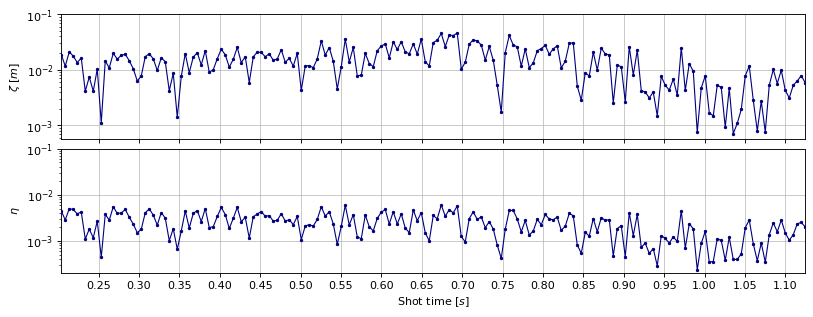

In [29]:
fig7, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4.2), dpi=80)
plt.subplots_adjust(hspace=0.08)  # Adjust the horizontal space between subplots

ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, separatrix_dists, color='navy',  linewidth=1, marker='.', markersize=4, label='FreeGSNKE', zorder=10) 
ax1.set_ylabel(r'$\zeta$ $[m]$')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(0.1,max(times)+0.1,0.05))
ax1.set_yticks([1e-3, 1e-2, 1e-1])
ax1.set_xlim(min(times), max(times))
ax1.set_xticklabels([])
ax1.set_axisbelow(True)

# Creating the second y-axis
ax2.grid(zorder=0, alpha=0.75)
ax2.plot(times, separatrix_dists_alt, color='navy', linestyle="-", linewidth=1, marker='.', markersize=4, zorder=10) 
ax2.set_xlabel(r'Shot time [$s$]')
ax2.set_ylabel(r'$\eta$')
ax2.set_yscale('log') 
ax2.set_xticks(np.arange(0.1,max(times)+0.1,0.05))
ax2.set_yticks([1e-3, 1e-2, 1e-1])
ax2.set_xlim(min(times), max(times))
ax2.set_axisbelow(True)

plt.show()


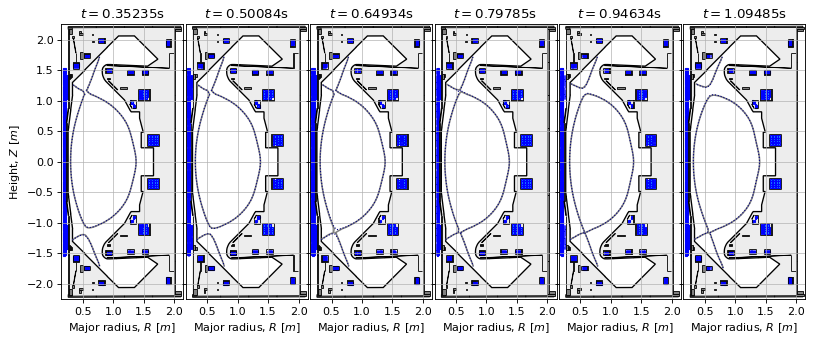

In [30]:
from matplotlib.path import Path

# some snapshots of the lower divertor for FreeGSNKE equilibria
snaps = [30, 60, 90, 120, 150, 180]

# common contour levels
levels = np.linspace(np.min(efit_psi_total[snaps[1],:,:]),np.max(efit_psi_total[snaps[1],:,:]),40)

fig7, (ax1, ax2, ax3, ax4,ax5, ax6) = plt.subplots(1, 6, figsize=(12, 6.3), dpi=80)
plt.subplots_adjust(wspace=0.02)  # Adjust the horizontal space between subplots

# Define the clipping path using the wall coordinates
clip_path = Path(np.column_stack((tokamak.wall.R, tokamak.wall.Z)))
mask = clip_path.contains_points(np.column_stack((eq.R.flatten(), eq.Z.flatten())))
mask = mask.reshape(eq.R.shape)
# mask = np.full((65,65), True)

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax1.add_patch(rect0)
eq.tokamak.plot(axis=ax1, show=False)
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax1.contour(eq.R, eq.Z, np.ma.masked_array(efit_psi_total[snaps[0],:,:], mask=~mask), levels=[efit_psi_boundary[snaps[0]]], colors='tab:gray', linestyles = 'solid', linewidths=1.4)
ax1.contour(eq.R, eq.Z, np.ma.masked_array(freegsnke_eqs[snaps[0]].psi(), mask=~mask), levels=[freegsnke_eqs[snaps[0]].psi_bndry], colors='navy', linestyles = 'dotted', linewidths=1.0)
ax1.grid(alpha=0.75)
ax1.set_aspect('equal')
ax1.set_xlabel(r'Major radius, $R$ $[m]$')
ax1.set_ylabel(r'Height, $Z$ $[m]$')
ax1.set_xticks(np.arange(0.5,2.1,0.5))
ax1.set_xlim(0.15, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(f"$t = {times[snaps[0]]}$s")


rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax2.add_patch(rect0)
eq.tokamak.plot(axis=ax2, show=False)
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax2.contour(eq.R, eq.Z, np.ma.masked_array(efit_psi_total[snaps[1],:,:], mask=~mask), levels=[efit_psi_boundary[snaps[1]]], colors='tab:gray', linestyles = 'solid', linewidths=1.4)
ax2.contour(eq.R, eq.Z, np.ma.masked_array(freegsnke_eqs[snaps[1]].psi(), mask=~mask), levels=[freegsnke_eqs[snaps[1]].psi_bndry], colors='navy', linestyles = 'dotted', linewidths=1.0)
ax2.grid(alpha=0.75)
ax2.set_aspect('equal')
ax2.set_xlabel(r'Major radius, $R$ $[m]$')
ax2.set_xticks(np.arange(0.5,2.1,0.5))
ax2.set_xlim(0.15, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_yticklabels([])
ax2.set_title(f"$t = {times[snaps[1]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax3.add_patch(rect0)
eq.tokamak.plot(axis=ax3, show=False)
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax3.contour(eq.R, eq.Z, np.ma.masked_array(efit_psi_total[snaps[2],:,:], mask=~mask), levels=[efit_psi_boundary[snaps[2]]], colors='tab:gray', linestyles = 'solid', linewidths=1.4)
ax3.contour(eq.R, eq.Z, np.ma.masked_array(freegsnke_eqs[snaps[2]].psi(), mask=~mask), levels=[freegsnke_eqs[snaps[2]].psi_bndry], colors='navy', linestyles = 'dotted', linewidths=1.0)
ax3.grid(alpha=0.75)
ax3.set_aspect('equal')
ax3.set_xlabel(r'Major radius, $R$ $[m]$')
# ax3.set_ylabel(r'Height $[m]$')
ax3.set_xticks(np.arange(0.5,2.1,0.5))
ax3.set_xlim(0.15, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_yticklabels([])
ax3.set_title(f"$t = {times[snaps[2]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax4.add_patch(rect0)
eq.tokamak.plot(axis=ax4, show=False)
ax4.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax4.contour(eq.R, eq.Z, np.ma.masked_array(efit_psi_total[snaps[3],:,:], mask=~mask), levels=[efit_psi_boundary[snaps[3]]], colors='tab:gray', linestyles = 'solid', linewidths=1.4)
ax4.contour(eq.R, eq.Z, np.ma.masked_array(freegsnke_eqs[snaps[3]].psi(), mask=~mask), levels=[freegsnke_eqs[snaps[3]].psi_bndry], colors='navy', linestyles = 'dotted', linewidths=1.0)
ax4.grid(alpha=0.75)
ax4.set_aspect('equal')
ax4.set_xlabel(r'Major radius, $R$ $[m]$')
# ax4.set_ylabel(r'Height $[m]$')
ax4.set_xticks(np.arange(0.5,2.1,0.5))
ax4.set_xlim(0.15, 2.15)
ax4.set_ylim(-2.25, 2.25)
ax4.set_yticklabels([])
ax4.set_title(f"$t = {times[snaps[3]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax5.add_patch(rect0)
eq.tokamak.plot(axis=ax5, show=False)
ax5.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax5.contour(eq.R, eq.Z, np.ma.masked_array(efit_psi_total[snaps[4],:,:], mask=~mask), levels=[efit_psi_boundary[snaps[4]]], colors='tab:gray', linestyles = 'solid', linewidths=1.4)
ax5.contour(eq.R, eq.Z, np.ma.masked_array(freegsnke_eqs[snaps[4]].psi(), mask=~mask), levels=[freegsnke_eqs[snaps[4]].psi_bndry], colors='navy', linestyles = 'dotted', linewidths=1.0)
ax5.grid(alpha=0.75)
ax5.set_aspect('equal')
ax5.set_xlabel(r'Major radius, $R$ $[m]$')
# ax5.set_ylabel(r'Height $[m]$')
ax5.set_xticks(np.arange(0.5,2.1,0.5))
ax5.set_xlim(0.15, 2.15)
ax5.set_ylim(-2.25, 2.25)
ax5.set_yticklabels([])
ax5.set_title(f"$t = {times[snaps[4]]}$s")

rect0 = patches.Rectangle((0.26, -2.21), 1.74, 4.42, edgecolor='none', facecolor='lightgrey', alpha=0.4, zorder=0)
ax6.add_patch(rect0)
eq.tokamak.plot(axis=ax6, show=False)
ax6.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax6.contour(eq.R, eq.Z, np.ma.masked_array(efit_psi_total[snaps[5],:,:], mask=~mask), levels=[efit_psi_boundary[snaps[5]]], colors='tab:gray', linestyles = 'solid', linewidths=1.4)
ax6.contour(eq.R, eq.Z, np.ma.masked_array(freegsnke_eqs[snaps[5]].psi(), mask=~mask), levels=[freegsnke_eqs[snaps[5]].psi_bndry], colors='navy', linestyles = 'dotted', linewidths=1.0)
ax6.grid(alpha=0.75)
ax6.set_aspect('equal')
ax6.set_xlabel(r'Major radius, $R$ $[m]$')
# ax6.set_ylabel(r'Height $[m]$')
ax6.set_xticks(np.arange(0.5,2.1,0.5))
ax6.set_xlim(0.15, 2.15)
ax6.set_ylim(-2.25, 2.25)
ax6.set_yticklabels([])
ax6.set_title(f"$t = {times[snaps[5]]}$s")

# plt.tight_layout()  # Adjust subplots to fit into the figure area without overlapping
plt.show()

In [31]:
# INITIALISE PROBES
# -------------
tokamak.probes.initialise_setup(eq) 
print('Magnetic probes initialised in the tokamak.')


Magnetic probes initialised in the tokamak.


In [32]:
# CALCULATE PROBE VALUES IN FREEGSNKE
# ------------- 

# get the names of the probes
probe_names = eq.tokamak.probes.floop_order + eq.tokamak.probes.pickup_order
        
probe_values = np.zeros((len(probe_names),len(times)))
for i in range(0,n):
    
    # compute fluxloop and pickup coil values from equilibrium 
    probe_values[:,i] = np.concatenate([
        tokamak.probes.calculate_fluxloop_value(freegsnke_eqs[i])*2*np.pi, # multiply by 2pi to match flux units in UDA
        tokamak.probes.calculate_pickup_value(freegsnke_eqs[i])
    ])
    
# fluxloop and pickup coil locations
probe_locations = np.concatenate([
    eq.tokamak.probes.floop_pos, 
    eq.tokamak.probes.pickup_pos[:,0::2]
])


In [33]:
# EXTRACT FLUXLOOP/PICKUP COIL MEASUREMENTS FROM EFIT DATA AT EACH TIME STEP REQUIRED
# -------------

# extract the probe names with values (will be less than the names in probe_names)
mastu_names = list(efit_fluxloops['names']) + list(efit_pickups['names'])

# concatenate all values (not all probes will return values)
# mastu_values = np.concatenate((raw_fluxloops['target'].T,raw_pickups['target'].T), axis=0)
mastu_values = np.concatenate((efit_fluxloops['computed'].T, efit_pickups['computed'].T), axis=0)
mastu_values = mastu_values[:,time_indices]

mastu_sigmas = np.concatenate((efit_fluxloops['sigmas'].T, efit_pickups['sigmas'].T), axis=0)
mastu_sigmas = mastu_sigmas[:,time_indices]




# find the correct indices to link the measurement and FreeGSNKE data
ordered_freegsnke_values = np.zeros((len(mastu_names),len(times)))
ordered_freegsnke_locations = np.zeros((len(mastu_names),2))
for i, name in enumerate(mastu_names):
    index = probe_names.index(name)  
    ordered_freegsnke_values[i,:] = probe_values[index,:]
    ordered_freegsnke_locations[i,:] = probe_locations[index]



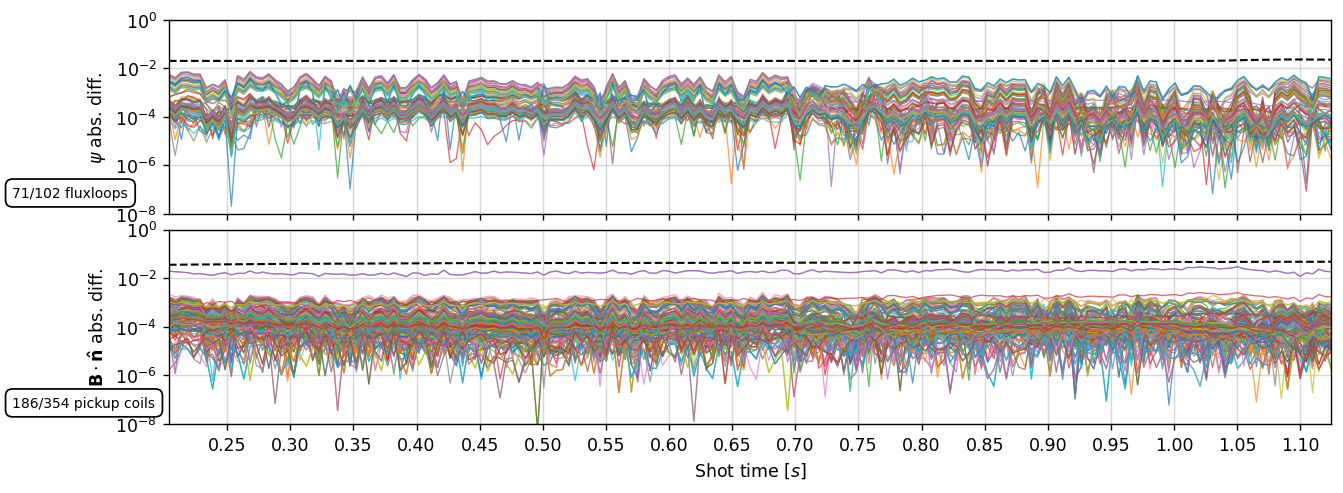

In [34]:
#PLOT THE ABS DIFFERENCES
# ------------- 

diff = np.abs(mastu_values - ordered_freegsnke_values)
i = len(efit_fluxloops['names'])


fig7, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4.2), dpi=125)
plt.subplots_adjust(hspace=0.08)  # Adjust the horizontal space between subplots

ax1.grid(zorder=0, alpha=0.5)
for j in range(0,i):
    ax1.plot(times, diff[j,:], linestyle="-", linewidth=0.75, alpha=0.7)
ax1.plot(times, np.max(mastu_sigmas[0:i,:], axis=0), 'k', linestyle="--", linewidth=1.2)
ax1.text(0.08, 5e-8, rf'{i}/{len(eq.tokamak.probes.floop_order)} fluxloops', color='k', fontsize=8, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# ax1.set_aspect('equal')
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$\psi$ abs. diff.')
ax1.set_yscale('log')
# ax1.set_ylim(-2.2, 2.2)
ax1.set_xticks(np.arange(0.1,max(times)+0.1,0.05))
ax1.set_yticks([1e-8, 1e-6, 1e-4, 1e-2, 1e0])
ax1.set_xticklabels([])
ax1.set_xlim(min(times), max(times))
ax1.set_ylim(1e-8, 1e0)
# ax1.legend(loc='lower left')
ax1.set_axisbelow(True)

# Creating the second y-axis
ax2.grid(zorder=0, alpha=0.5)
for j in range(i,len(mastu_names)):
    ax2.plot(times, diff[j,:], linestyle="-", linewidth=0.75, alpha=0.7)
ax2.plot(times, np.max(mastu_sigmas[i::,:], axis=0), 'k', linestyle="--", linewidth=1.2)
ax2.text(0.08, 5e-8, rf'{(len(mastu_names)-i)}/{len(eq.tokamak.probes.pickup_order)} pickup coils', color='k', fontsize=8, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

ax2.set_xlabel(r'Shot time [$s$]')
ax2.set_ylabel(r'$\mathbf{B} \cdot \mathbf{\hat{n}}$ abs. diff.')
ax2.set_yscale('log') 
ax2.set_xticks(np.arange(0.1,max(times)+0.1,0.05))
ax2.set_yticks([1e-8, 1e-6, 1e-4, 1e-2, 1e0])
ax2.set_ylim(1e-8, 1e0)
ax2.set_xlim(min(times), max(times))
ax2.set_axisbelow(True)

plt.show()


### Extra: Tension spline example 

Here, we briefly show how to interpolate and reproduce a cubic function using the tension spline.

In [35]:
# example (y = x**3 + 1)

# inputs
x = np.linspace(-2,2,32)
xn = np.array([-2, -1, 0, 2])
yn = np.array([-7, 0, 1, 9])
zn = np.array([-12, -6, 0, 12])
sigma = 0.01

# call the spline function 
y = tension_spline(x, xn, yn, zn, sigma)

# rough calculation of the error
np.max(np.abs((x**3 + 1) - y))   # max error


0.0001247063365568124

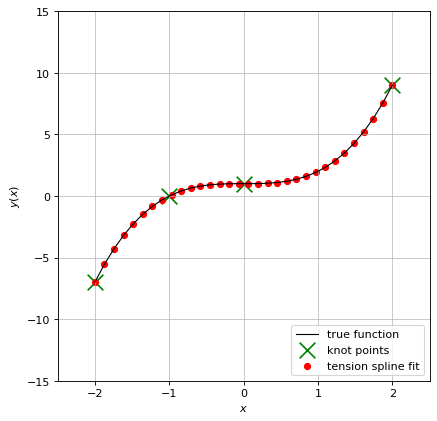

In [36]:
# plot
fig1, ax1, = plt.subplots(1, 1, figsize=(6,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(x, x**3 + 1, color='k', linewidth=1, label='true function')
ax1.scatter(xn, yn, s=200, color='g', marker='x', label='knot points')
ax1.scatter(x, y, s=30, color='r', label='tension spline fit')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r"$y(x)$")
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-15, 15)
plt.legend(loc="lower right")